## Dataset

In [89]:
import pandas as pd

df = pd.read_csv("bank-full.csv", sep=";")

In [90]:
df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no


In [91]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [92]:
req_features = [
    "age", "job", "marital", "education", "balance", "housing", "contact", "day", "month",
    "duration", "campaign", "pdays", "previous", "poutcome"]

In [93]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"train len = {len(df_train)}, val len = {len(df_val)}, test len = {len(df_test)}")

train len = 27126, val len = 9042, test len = 9043


In [94]:
df_full_train.reset_index(drop=True)
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = (df_train.y == "yes").astype(int)
y_val = (df_val.y == "yes").astype(int)
y_test = (df_test.y == "yes").astype(int)

del df_train["y"]
del df_val["y"]
del df_test["y"]

In [95]:
numerical_cols = list(df_train.dtypes[df_train.dtypes != "object"].index)
categorical_cols = list(filter(lambda x: x not in numerical_cols, req_features))

In [96]:
categorical_cols

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [97]:
print(len(df_full_train.columns))
print(f"train: {df_train.shape}, val: {df_val.shape}, test: {df_test.shape}")

17
train: (27126, 16), val: (9042, 16), test: (9043, 16)


## Feature importance of numerical vars

- Filter out numerical features
- Assume y_train as ground truth
- Calculate AUC using numerical feature as prediction

This approach is possible because ROC does not necessarily operate on probabilities - any ranking will do. In this case, samples are ranked based on relative values of given num feature.

In [98]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

scores = dict()
for col in numerical_cols:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    scores[col] = score.round(4)

sorted(scores.items(), key=lambda x: x[1])

[('age', np.float64(0.5122)),
 ('day', np.float64(0.526)),
 ('campaign', np.float64(0.5715)),
 ('balance', np.float64(0.5888)),
 ('pdays', np.float64(0.5901)),
 ('previous', np.float64(0.5986)),
 ('duration', np.float64(0.8147))]

## Reference model AUC

In [99]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [100]:
dv_ref = DictVectorizer(sparse=False)
dicts = df_train[categorical_cols + numerical_cols].to_dict(orient="records")
dv_ref.fit(dicts)

DictVectorizer(sparse=False)

In [101]:
dv_ref.get_feature_names_out()

array(['age', 'balance', 'campaign', 'contact=cellular',
       'contact=telephone', 'contact=unknown', 'day', 'duration',
       'education=primary', 'education=secondary', 'education=tertiary',
       'education=unknown', 'housing=no', 'housing=yes', 'job=admin.',
       'job=blue-collar', 'job=entrepreneur', 'job=housemaid',
       'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'job=unknown', 'marital=divorced', 'marital=married',
       'marital=single', 'month=apr', 'month=aug', 'month=dec',
       'month=feb', 'month=jan', 'month=jul', 'month=jun', 'month=mar',
       'month=may', 'month=nov', 'month=oct', 'month=sep', 'pdays',
       'poutcome=failure', 'poutcome=other', 'poutcome=success',
       'poutcome=unknown', 'previous'], dtype=object)

In [102]:
print("# cols after one-hot conversion:")
print(len(dv_ref.get_feature_names_out()))

# cols after one-hot conversion:
47


In [103]:
ref_model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
X_train = dv_ref.transform(dicts)
ref_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [104]:
print(ref_model.coef_[0].round(3))
print(ref_model.intercept_[0].round(3))

[-0.003  0.    -0.088  0.219  0.132 -1.32   0.008  0.004 -0.42  -0.244
 -0.088 -0.218 -0.165 -0.805  0.007 -0.298 -0.267 -0.362 -0.1    0.376
 -0.165 -0.167  0.528 -0.232 -0.152 -0.137 -0.344 -0.44  -0.185 -0.122
 -0.704  0.274 -0.388 -1.272 -0.939  0.424  1.589 -0.525 -1.006  0.982
  0.716 -0.    -0.781 -0.739  1.469 -0.919  0.014]
-0.97


In [105]:
dicts_val = df_val[categorical_cols + numerical_cols].to_dict(orient="records")
X_val = dv_ref.transform(dicts_val)
y_probs = ref_model.predict_proba(X_val)[:, 1]
ref_score = roc_auc_score(y_val, y_probs)
print(f"ref auc = {ref_score.round(3)}")

ref auc = 0.9


## Precision and recall

crossover @ 0.265


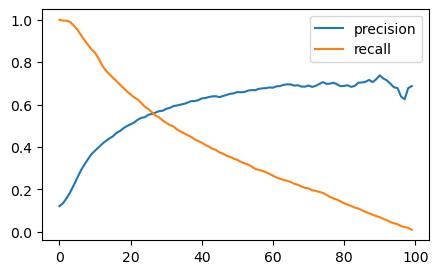

In [106]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0., 1., 0.01)
y_probs = ref_model.predict_proba(X_val)[:, 1]

scores = []
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    scores.append((t, precision, recall))

plt.subplots(figsize=(5, 3))
plt.plot(list(s[1] for s in scores), label="precision")
plt.plot(list(s[2] for s in scores), label="recall")
plt.legend()

def crossover(scores):
    h, l = None, scores[0][0]
    for score in scores:
        t, precision, recall = score
        if precision > recall:
            h = t
            break
        l = t
    return (h + l) / 2

t = crossover(scores)
print(f"crossover @ {t}")

## F1 score

f1_max @ 0.22 = 0.5728601252609603


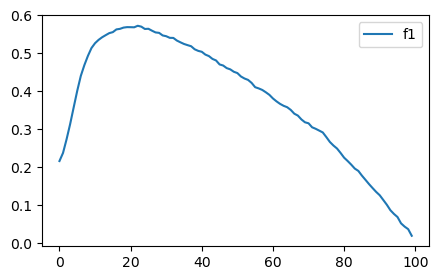

In [107]:
thresholds = np.arange(0., 1., 0.01)
y_probs = ref_model.predict_proba(X_val)[:, 1]

scores = []
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = 2 * (precision * recall / (precision + recall))
    scores.append((t, f1))

plt.subplots(figsize=(5, 3))
plt.plot(list(s[1] for s in scores), label="f1")
plt.legend()

f1_max = max(scores, key=lambda x: x[1])
print(f"f1_max @ {f1_max[0]} = {f1_max[1]}")

## K-fold CV

In [133]:
from tqdm import tqdm
from sklearn.model_selection import KFold

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []
dv = DictVectorizer(sparse=False)
dicts = df_full_train[categorical_cols + numerical_cols].to_dict(orient="records")
dv.fit(dicts)

scores = []
for t, v in tqdm(kfold.split(df_full_train)):
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    d_train = df_full_train.iloc[t]
    d_val = df_full_train.iloc[v]
    X_train = dv.transform(d_train[categorical_cols + numerical_cols].to_dict(orient="records"))
    X_val = dv.transform(d_val[categorical_cols + numerical_cols].to_dict(orient="records"))
    y_train = (d_train.y == "yes").astype(int)
    y_val = (d_val.y == "yes").astype(int)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_probs)
    scores.append(score)
    
print(f"mean auc = {np.mean(scores).round(6)}")
print(f"std auc = {np.std(scores).round(6)}")

5it [00:01,  2.66it/s]

mean auc = 0.906028
std auc = 0.005621


## Hparam tuning

In [138]:
n_splits = 5
c_vals = [0.000001, 0.001, 1]
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = dict()
for c in c_vals:
    scores[c] = []
    for t, v in tqdm(kfold.split(df_full_train)):
        model = LogisticRegression(solver="liblinear", C=c, max_iter=1000)
        d_train = df_full_train.iloc[t]
        d_val = df_full_train.iloc[v]
        X_train = dv.transform(d_train[categorical_cols + numerical_cols].to_dict(orient="records"))
        X_val = dv.transform(d_val[categorical_cols + numerical_cols].to_dict(orient="records"))
        y_train = (d_train.y == "yes").astype(int)
        y_val = (d_val.y == "yes").astype(int)
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_probs)
        scores[c].append(score)

for c, auc_scores in scores.items():
    print(f"c = {c}, mean auc = {np.mean(auc_scores).round(3)}, std auc = {np.std(auc_scores).round(3)}")

5it [00:01,  3.32it/s]
5it [00:01,  2.93it/s]
5it [00:01,  2.63it/s]

c = 1e-06, mean auc = 0.701, std auc = 0.009
c = 0.001, mean auc = 0.861, std auc = 0.007
c = 1, mean auc = 0.906, std auc = 0.006
